In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from os.path import join as pjoin
import pandas as pd

mpl.style.use('../matts_tests/style.mcstyle')

In [2]:
lhid = 2
wdir = '../data'
solver='borgpm'
source_dir = pjoin(wdir, f'inf_3gpch/{solver}/L3000-N384', str(lhid))

lhpath = pjoin('../params', 'latin_hypercube_params.txt')
lh_lookup = pd.read_csv(
    lhpath, delimiter=' ', header=None, 
    names=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8'])
print(lh_lookup.iloc[lhid+1])

Omega_m    0.32710
Omega_b    0.06875
h          0.63130
n_s        0.81350
sigma_8    0.89390
Name: 3, dtype: float64


In [3]:
rho = np.load(pjoin(source_dir, 'rho.npy'))
fvel = np.load(pjoin(source_dir, 'fvel.npy'))
hpos = np.load(pjoin(source_dir, 'halo_pos.npy'))
hcpos = np.load(pjoin(source_dir, 'halo_cuboid_pos.npy'))
gcpos = np.load(pjoin(source_dir, 'hod', 'hod0_pos.npy'))
grdz = np.load(pjoin(source_dir, 'obs', 'rdz0.npy'))
Pk = np.load(pjoin(source_dir, 'Pk', 'Pk0.npz'))

In [4]:
di = np.array([65, 70])
dx = (3000/384)*di

(-0.5, 383.5, -0.5, 383.5)

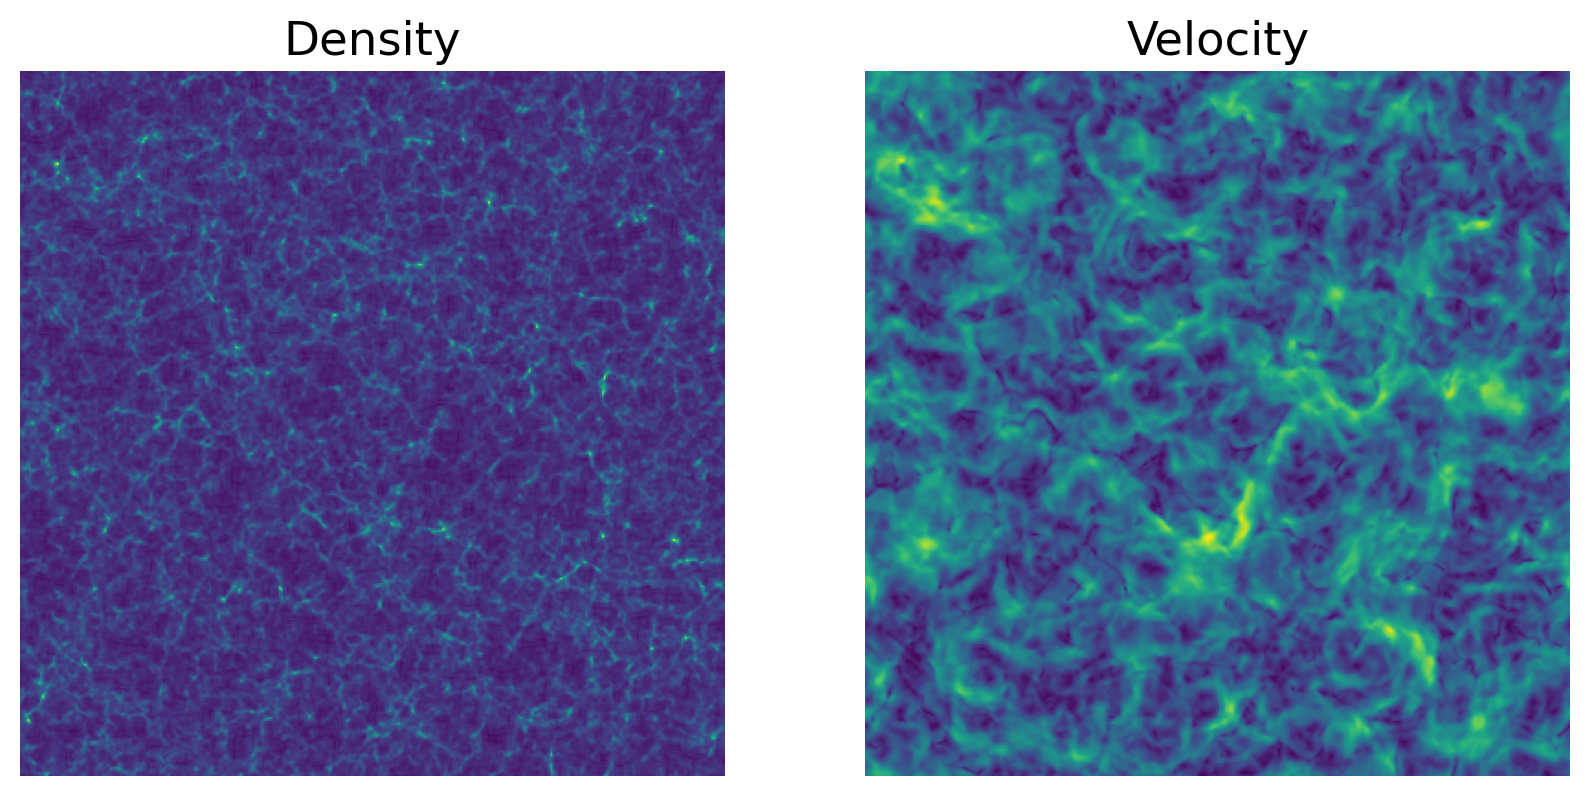

In [5]:
f, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].imshow(np.mean(rho[di[0]:di[1]], axis=0), vmin=-1, vmax=5)
axs[0].set_title('Density')
axs[0].axis('off')
axs[1].imshow(np.linalg.norm(np.mean(fvel[di[0]:di[1]], axis=0), axis=-1))
axs[1].set_title('Velocity')
axs[1].axis('off')


(0.0, 3000.0, 0.0, 3000.0)

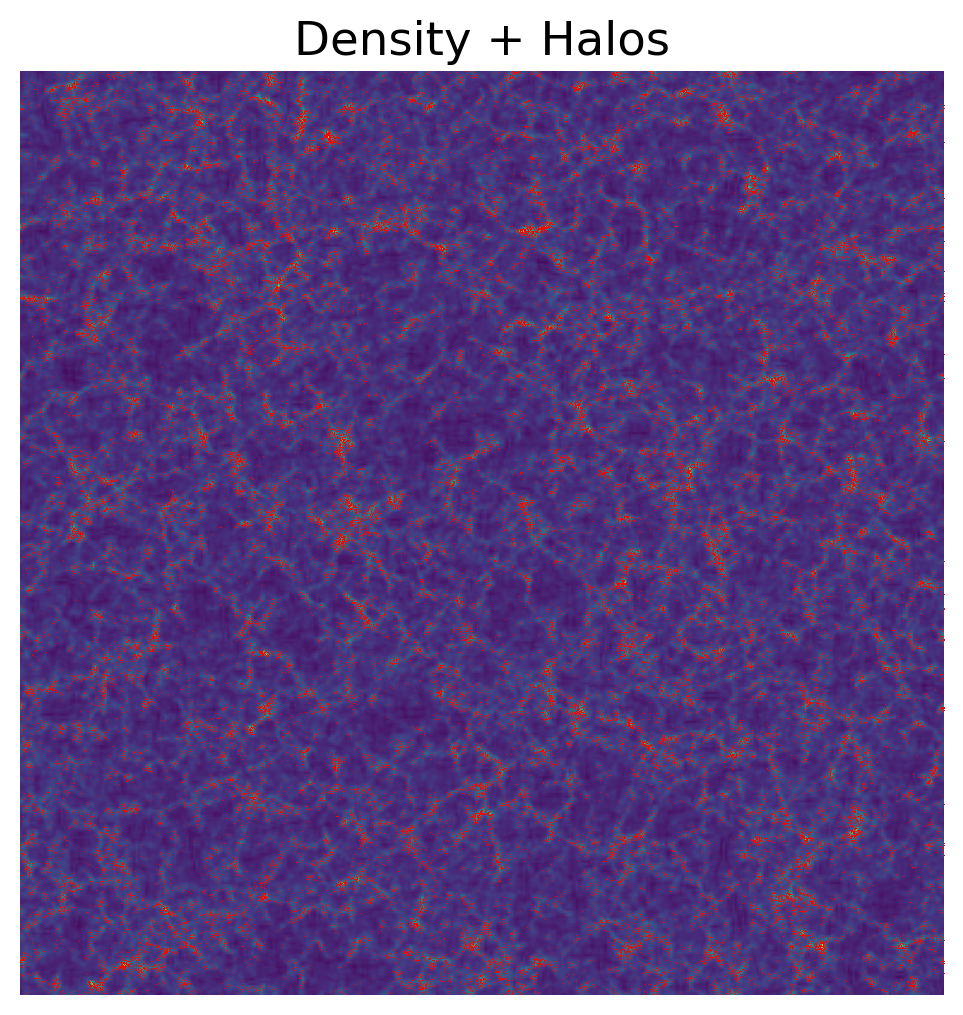

In [6]:
f, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.imshow(np.mean(rho[di[0]:di[1]], axis=0).T, vmin=-1, vmax=5,
              extent=[0,3e3,0,3e3], origin='lower')

mask = (dx[0] < hpos[:,0]) & (hpos[:,0] < dx[1])
ax.plot(hpos[mask,1], hpos[mask,2], 'r,', alpha=1)
ax.set_title('Density + Halos')
ax.axis('off')

(-149.9603520350531,
 3149.8991304168476,
 -105.97642691098154,
 2227.377713967487)

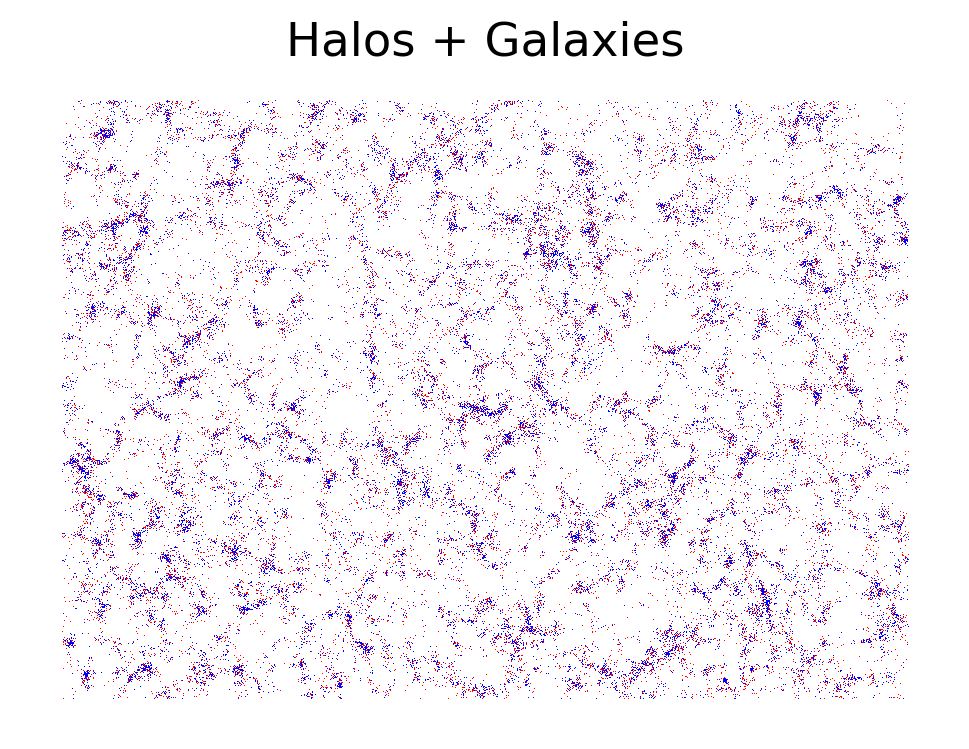

In [7]:
f, ax = plt.subplots(1, 1, figsize=(6, 6))

mask = (dx[0] < hcpos[:,0]) & (hcpos[:,0] < dx[1])
ax.plot(hcpos[mask,1], hcpos[mask,2], 'r,', alpha=1)
mask = (dx[0] < gcpos[:,0]) & (gcpos[:,0] < dx[1])
ax.plot(gcpos[mask,1], gcpos[mask,2], 'b,', alpha=1)
ax.set_title('Halos + Galaxies')
ax.set_aspect('equal')
ax.axis('off')

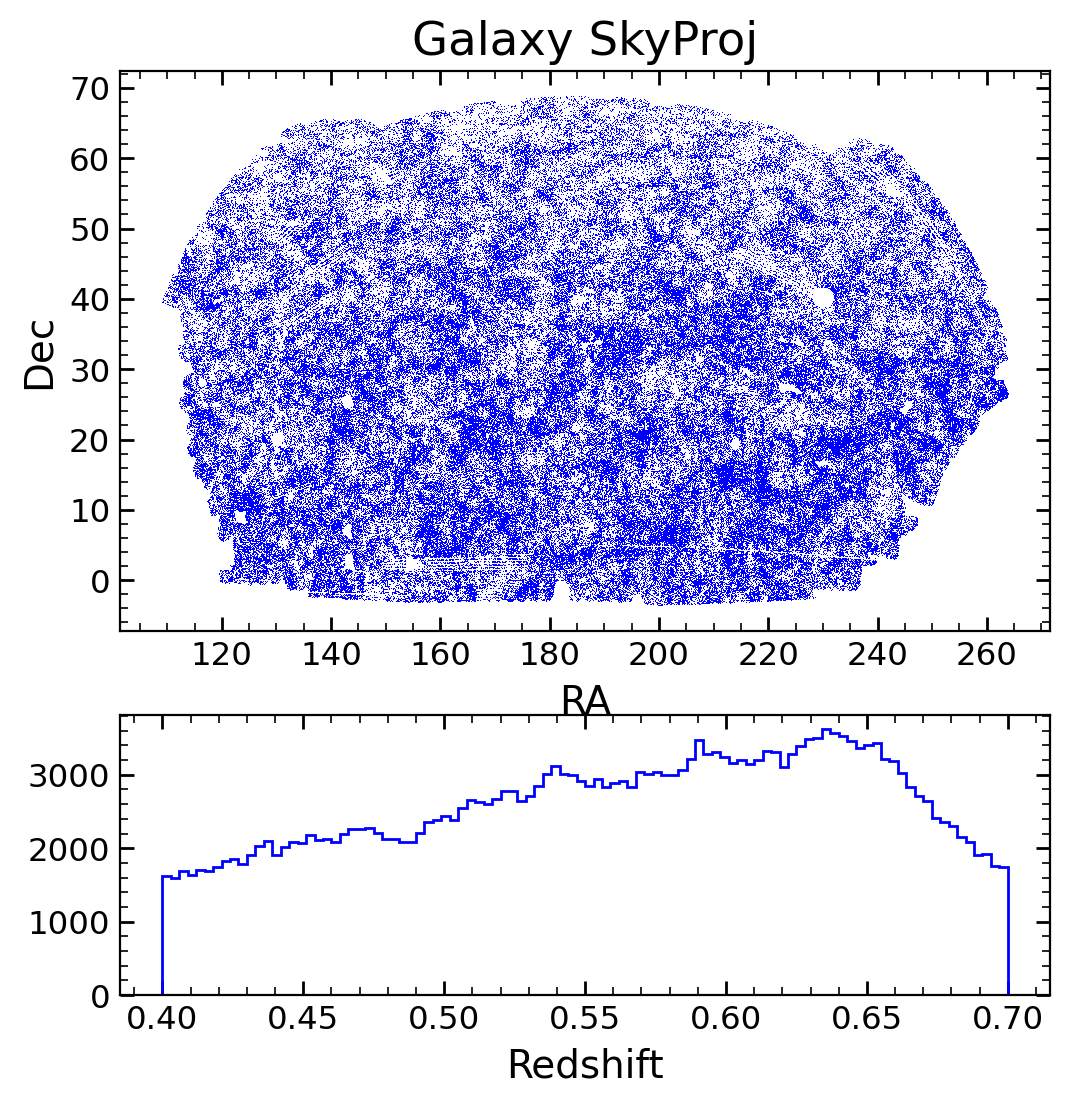

In [8]:
f, axs = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2,1]})

axs[0].plot(grdz[:,0], grdz[:,1], 'b,')
axs[0].set_title('Galaxy SkyProj')
axs[0].set_xlabel('RA')
axs[0].set_ylabel('Dec')

axs[1].hist(grdz[:,2], bins=100, histtype='step', color='b')
axs[1].set_xlabel('Redshift');

Text(0, 0.5, 'P(k)')

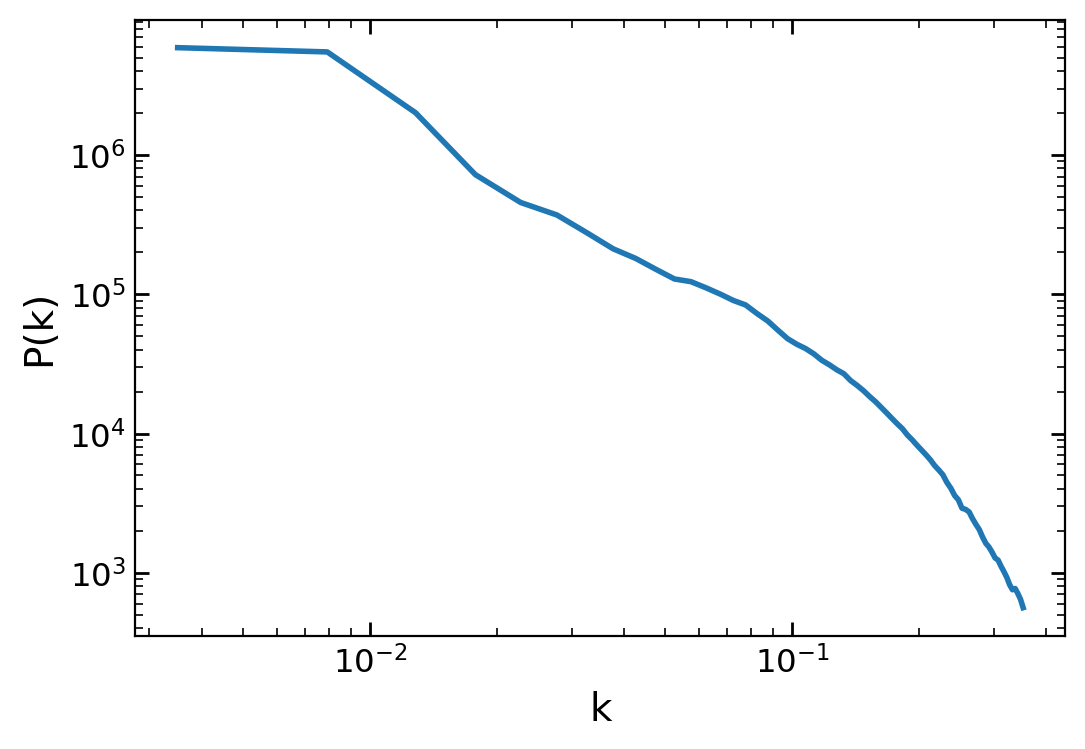

In [9]:
k = Pk['k_gal']
P0 = Pk['p0k_gal']

f, ax = plt.subplots(1, 1, figsize=(6,4))
ax.loglog()
ax.plot(k, P0)
ax.set_xlabel('k')
ax.set_ylabel('P(k)')


## Fixing

In [3]:
from cmass.summaries.tools import load_randoms_precomputed
randoms = np.load(pjoin('../data', 'obs', 'random0_DR12v5_CMASS_North_PRECOMPUTED.npy'))


In [3]:
import nbodykit.lab as nblab
from nbodykit import cosmology
from cmass.summaries.tools import (get_nofz, sky_to_xyz, load_galaxies_obs,
                                   load_randoms_precomputed)
from cmass.survey.tools import BOSS_area, BOSS_angular
cosmo = cosmology.Planck15
rrdz = randoms

ImportError: cannot import name 'load_randoms_precomputed' from 'cmass.summaries.tools' (/home/mattho/git/ltu-cmass/cmass/summaries/tools.py)

In [4]:

import pymangle
def BOSS_area():
    f_poly = os.path.join('../data', 'obs/mask_DR12v5_CMASSLOWZ_North.ply')
    boss_poly = pymangle.Mangle(f_poly)
    area = np.sum(boss_poly.areas * boss_poly.weights)  # deg^2
    return area

In [6]:
P0 = 1e4
Ngrid = 360
dk = 0.005
Nr = len(rrdz)
w_r = np.ones(Nr)
weights = np.ones(len(grdz))

gpos = sky_to_xyz(grdz, cosmo)
rpos = sky_to_xyz(rrdz, cosmo)

fsky = BOSS_area() / (360.**2 / np.pi)
ng_of_z = get_nofz(grdz[:, -1], fsky, cosmo=cosmo)
nbar_g = ng_of_z(grdz[:, -1])
nbar_r = ng_of_z(rrdz[:, -1])

_gals = nblab.ArrayCatalog({
    'Position': gpos,
    'NZ': nbar_g,
    'WEIGHT': weights,
    'WEIGHT_FKP': 1./(1. + nbar_g * P0)
})

_rands = nblab.ArrayCatalog({
    'Position': rpos,
    'NZ': nbar_r,
    'WEIGHT': w_r,
    'WEIGHT_FKP': 1./(1. + nbar_r * P0)
})

NameError: name 'grdz' is not defined

In [12]:
fkp = nblab.FKPCatalog(_gals, _rands)
mesh = fkp.to_mesh(Nmesh=Ngrid, nbar='NZ', fkp_weight='WEIGHT_FKP',
                    comp_weight='WEIGHT', window='tsc')

In [14]:
# field = mesh.to_real_field()
# plt.imshow(field.value[:,:,50].real)

## Check mask

In [5]:
# load survey
from astropy.io import fits
def load_galaxies(fname, fields):
    with fits.open(fname) as hdul:
        gals = np.array([hdul[1].data[x] for x in fields]).T
        gals = pd.DataFrame(gals, columns=fields)    
    return gals
# load data
fname = '../data/obs/galaxy_DR12v5_CMASS_North.fits'
fields = ['RA','DEC','Z',
          'WEIGHT_SYSTOT','WEIGHT_NOZ','WEIGHT_CP']
cmass = load_galaxies(fname, fields)

In [6]:
cmass['Z'].min(), cmass['Z'].max()

(-0.011446905322372913, 1.002165675163269)

In [8]:

from astropy.io import fits
from astropy.coordinates import search_around_sky
from astropy import units as u
from astropy.coordinates import SkyCoord

# from cmass.survey.tools import BOSS_angular, BOSS_veto, BOSS_redshift, BOSS_fiber
from cmass.survey.tools import gen_randoms

# def BOSS_angular(ra, dec):
#     ''' Given RA and Dec, check whether the galaxies are within the angular
#     mask of BOSS
#     '''
#     f_poly = os.path.join('../data', 'obs', 'mask_DR12v5_CMASS_North.ply')
#     mask = pymangle.Mangle(f_poly)

#     good = mask.contains(ra, dec)
#     w = mask.weight(ra, dec)
#     # print(np.mean(w), np.sum(w > 0.7), np.sum(w>0))
#     inpoly = good & (w > 0.7)
#     return inpoly


# def BOSS_veto(ra, dec, verbose=False):
#     ''' given RA and Dec, find the objects that fall within one of the veto 
#     masks of BOSS. At the moment it checks through the veto masks one by one.  
#     '''
#     in_veto = np.zeros(len(ra)).astype(bool)
#     fvetos = [
#         'badfield_mask_postprocess_pixs8.ply',
#         'badfield_mask_unphot_seeing_extinction_pixs8_dr12.ply',
#         'allsky_bright_star_mask_pix.ply',
#         'bright_object_mask_rykoff_pix.ply',
#         'centerpost_mask_dr12.ply',
#         'collision_priority_mask_dr12.ply']

#     veto_dir = '../data'
#     for fveto in fvetos:
#         if verbose:
#             print(fveto)
#         veto = pymangle.Mangle(os.path.join(veto_dir, 'obs', fveto))
#         w_veto = veto.weight(ra, dec)
#         print(np.sum(w_veto > 0.), len(ra))
#         in_veto = in_veto | (w_veto > 0.)
#     return in_veto


# def BOSS_redshift(z):
#     zmin, zmax = 0.4, 0.7
#     mask = (zmin < z) & (z < zmax)
#     return np.array(mask)


# def BOSS_fiber(ra, dec, sep=0.01722, mode=1):
#     c = SkyCoord(ra=ra, dec=dec, unit=u.degree)
#     seplimit = sep*u.degree
#     idx1, idx2, _, _ = search_around_sky(c, c, seplimit)

#     if mode == 1:
#         iddrop = idx1[idx1 != idx2]
#     elif mode == 2:
#         iddrop = np.array(
#             list(set(idx1[idx1 != idx2]).union(idx2[idx1 != idx2])),
#             dtype=int)
#     else:
#         raise ValueError(f'Fiber collision type {mode} is not valid.')

#     mask = np.ones(len(ra), dtype=bool)
#     mask[iddrop] = False
#     return mask


# def BOSS_area():
#     f_poly = os.path.join('../data', 'obs/mask_DR12v5_CMASSLOWZ_North.ply')
#     boss_poly = pymangle.Mangle(f_poly)
#     area = np.sum(boss_poly.areas * boss_poly.weights)  # deg^2
#     return area

# # load randoms
# def gen_randoms():
#     fname = '../data/obs/random0_DR12v5_CMASS_North.fits'
#     fields = ['RA', 'DEC', 'Z']
#     print('loading')
#     with fits.open(fname) as hdul:
#         randoms = np.array([hdul[1].data[x] for x in fields]).T
#         randoms = pd.DataFrame(randoms, columns=fields)

#     print('n_z')
#     n_z = np.load(pjoin('../data', 'obs', 'n-z_DR12v5_CMASS_North.npy'),
#                   allow_pickle=True).item()
#     be, hobs = n_z['be'], n_z['h']
#     cutoffs = np.cumsum(hobs) / np.sum(hobs)
#     w = np.diff(be[:2])[0]

#     print('redshifts')
#     prng = np.random.uniform(size=len(randoms))
#     randoms['Z'] = be[:-1][cutoffs.searchsorted(prng)]
#     randoms['Z'] += w * np.random.uniform(size=len(randoms))

#     print('angular')
#     # further selection functions
#     mask = BOSS_angular(randoms['RA'], randoms['DEC'])
#     randoms = randoms[mask]
#     print('redshift')
#     mask = BOSS_redshift(randoms['Z'])
#     randoms = randoms[mask]
#     # print('veto')
#     # mask = (~BOSS_veto(randoms['RA'], randoms['DEC'], verbose=True))
#     # randoms = randoms[mask]

#     return randoms.values
randoms0 = gen_randoms(wdir='../data')

badfield_mask_postprocess_pixs8.ply
badfield_mask_unphot_seeing_extinction_pixs8_dr12.ply
allsky_bright_star_mask_pix.ply
bright_object_mask_rykoff_pix.ply
centerpost_mask_dr12.ply
collision_priority_mask_dr12.ply


(25.0, 40.0)

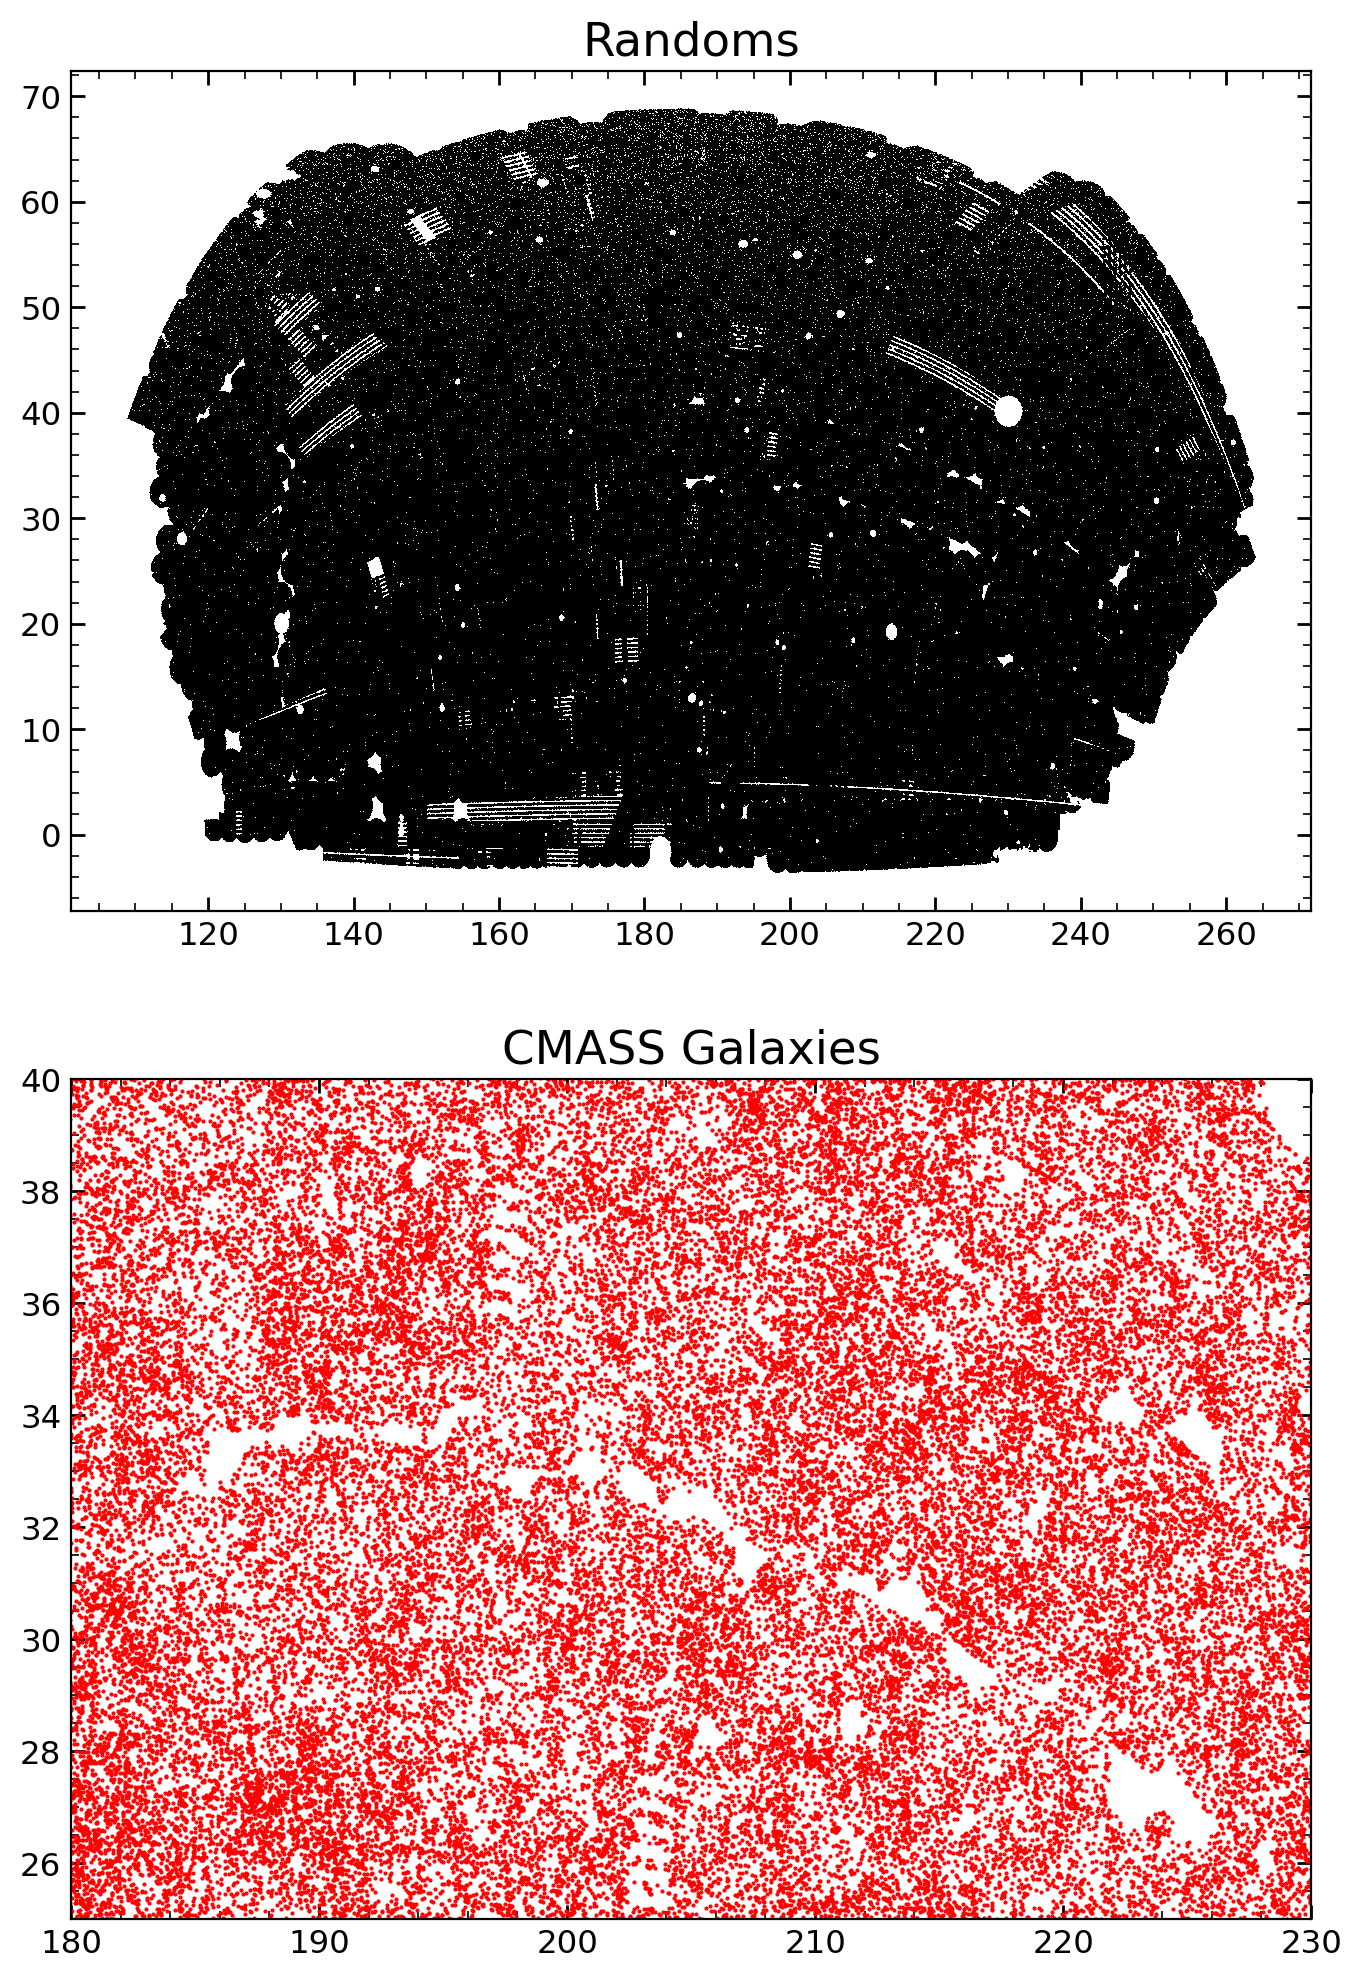

In [10]:

f, axs = plt.subplots(2,1, figsize=(8,12))
mask = np.random.rand(randoms0.shape[0]) < 0.1
axs[0].plot(randoms0[mask,0], randoms0[mask,1], 'k,')
axs[0].set_title('Randoms')
# axs[0].set_xlim(180, 230)
# axs[0].set_ylim(25,40)

mask = (0.4 < cmass['Z']) & (cmass['Z'] < 0.7)
axs[1].plot(cmass['RA'][mask], cmass['DEC'][mask], 'r.', markersize=1)
axs[1].set_title('CMASS Galaxies');
axs[1].set_xlim(180, 230)
axs[1].set_ylim(25,40)


In [27]:
fname = '../data/obs/random0_DR12v5_CMASS_North.fits'
fields = ['RA', 'DEC', 'Z']
print('loading')
with fits.open(fname) as hdul:
    randoms = np.array([hdul[1].data[x] for x in fields]).T
    randoms = pd.DataFrame(randoms, columns=fields)

print('n_z')
n_z = np.load(pjoin('../data', 'obs', 'n-z_DR12v5_CMASS_North.npy'),
                allow_pickle=True).item()
be, hobs = n_z['be'], n_z['h']
cutoffs = np.cumsum(hobs) / np.sum(hobs)
w = np.diff(be[:2])[0]

print('redshifts')
prng = np.random.uniform(size=len(randoms))
randoms['Z'] = be[:-1][cutoffs.searchsorted(prng)]
randoms['Z'] += w * np.random.uniform(size=len(randoms))

print('redshift')
mask = BOSS_redshift(randoms['Z'])
randoms = randoms[mask]

print('angular')
ra, dec = randoms['RA'], randoms['DEC']
f_poly = os.path.join('../data', 'obs', 'mask_DR12v5_CMASS_North.ply')
mask = pymangle.Mangle(f_poly)

w = mask.weight(ra, dec)

loading
n_z
redshifts
redshift
angular


In [36]:
# randoms = randoms[['RA', 'DEC', 'Z']].values
# randoms.shape
w.shape

(32136827,)

(25.0, 40.0)

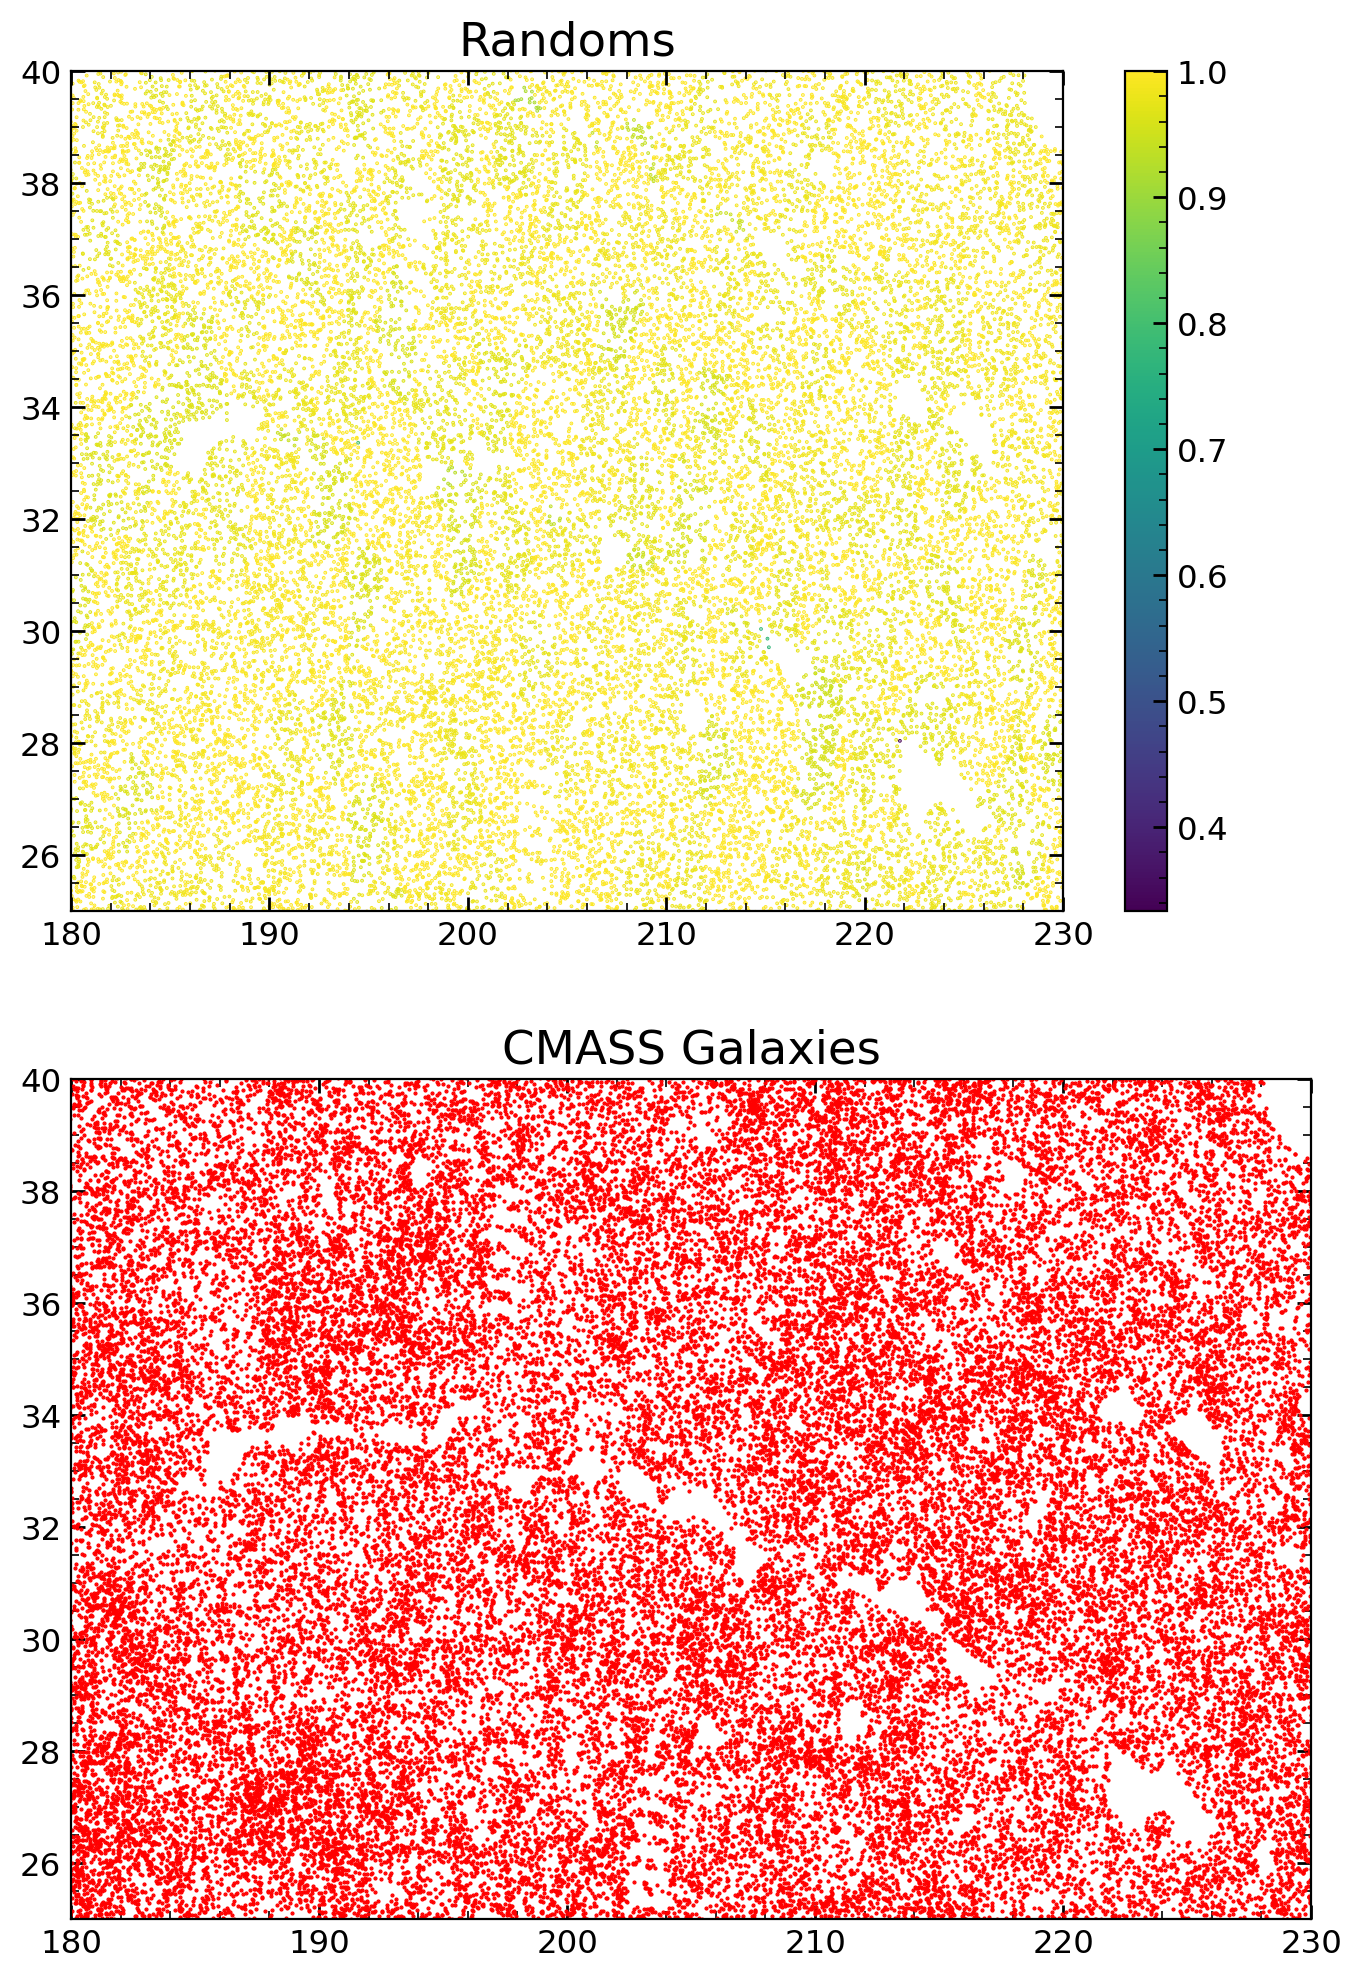

In [40]:
f, axs = plt.subplots(2,1, figsize=(8,12))
mask = np.random.rand(randoms.shape[0]) < 0.01
im = axs[0].scatter(randoms[mask,0], randoms[mask,1], c=w[mask], marker='.', s=0.5, cmap='')
axs[0].set_title('Randoms')
axs[0].set_xlim(180, 230)
axs[0].set_ylim(25,40)
plt.colorbar(im)

mask = (0.4 < cmass['Z']) & (cmass['Z'] < 0.7)
axs[1].plot(cmass['RA'][mask], cmass['DEC'][mask], 'r.', markersize=1)
axs[1].set_title('CMASS Galaxies');
axs[1].set_xlim(180, 230)
axs[1].set_ylim(25,40)